# Goodreads Aura
The Librarians (Ananya Purwar, Laura Vairus, James Duffy)

#Overview

**Welcome!** In this tutorial you will learn how to generate your very own Goodreads Aura, a colorful image based on the genres of the books you read!
You will follow the general outline:
- Building and training an NLP Classification Model
- Importing your Goodreads data!
- Webscraping the Goodreads site to get the descriptions for each of your books!
- Finding your most read genres using the NLP model!
- Creating an aura visualization based on your most read genres!

Once this tutorial is complete, you should have a visualization similar to a [Spotify Aura](https://engineering.atspotify.com/2021/12/the-audio-aura-story-mystical-to-mathematical/)!

**Before we start,** we'll import some libraries.
- pandas will help us make dataframes to store and organize information
- bs4 and requests will help us webscrape

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

We will also clone in a github repository with all the data you'll need. Just run the code below to load it in.

In [ ]:
!git clone https://github.com/lvairus/genre-visualization-tutorial.git

Cloning into 'CS123GoodreadsAura'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 5), reused 18 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 6.40 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (5/5), done.


# NLP Classification Model

A classification model takes an input and outputs one of multiple classes. In our case, we will be inputting book descriptions and outputting what genre they're in.

## Training Data

we'll start by reading in the data to train our model We've provided it so all you have to do is load it in


In [ ]:
df = pd.read_csv("/content/CS123GoodreadsAura/desc_to_genre_data.csv")
df.head()

,title,desc,genres,core
0,The Hunger Games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",fantasy
1,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",fantasy
2,Twilight,About three things I was absolutely positive.\...,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",fantasy
3,Animal Farm,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",fantasy
4,The Chronicles of Narnia,"Journeys to the end of the world, fantastic cr...","['Fantasy', 'Classics', 'Fiction', 'Young Adul...",fantasy


This data has columns for book name, book description, a list of its genres, and it's core (or main) genre. Let's take a closer look at the core column

In [ ]:
df.value_counts("core")

,count
core,
action/adventure,1000
fantasy,1000
horror/thriller,1000
mystery,1000
nonfiction,1000
other,1000
romance,1000
science fiction,1000


so there are 8 core genres and 1000 books for each one.

In natural language processing, it's also important to see how big your texts are to see how much data you will have to process. Let's figure out how long the descriptions are by running the following code.

In [ ]:
df["length"] = df["desc"].apply(len)

Now let's take a look at the results

array([[<Axes: title={'center': 'length'}>]], dtype=object)

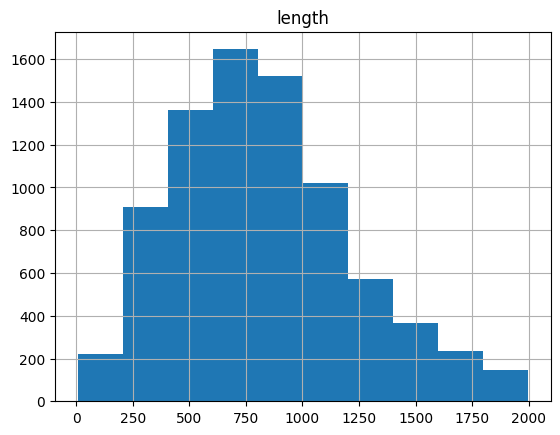

In [ ]:
df.hist(column="length")

So it looks like most descriptions are around 800 characters long, and they range between 0-2000 characters. Great job!

Feel free to do your own exploration of the training data before moving forward!

## Pre-Processing

The next thing we'll want to do is preprocess our text.

In natual language processing, we want our models to only pay attention to the important words across different documents. All texts have punctuation and stopwords (common words such as "the", "a", etc) regardless of what kind of text they are. Therefore we'll want to preprocess our data to take out all of these to only leave important words for our model to process.

we can get a list of punctuation using the string library

In [ ]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


we can get a list of stopwords from the nltk.corpus library

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's start by preprocessing the first book description in our dataframe.

In [ ]:
text = df["desc"][0]
print(text)

WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love.


Let's first normalize it to all lowercase

In [ ]:
preprocessed_text = text.lower()
print(preprocessed_text)

winning means fame and fortune.losing means certain death.the hunger games have begun. . . .in the ruins of a place once known as north america lies the nation of panem, a shining capitol surrounded by twelve outlying districts. the capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual hunger games, a fight to the death on live tv.sixteen-year-old katniss everdeen regards it as a death sentence when she steps forward to take her sister's place in the games. but katniss has been close to dead before—and survival, for her, is second nature. without really meaning to, she becomes a contender. but if she is to win, she will have to start making choices that weight survival against humanity and life against love.


Then we'll go word by word and take out all of the stopwords

In [ ]:
preprocessed_text = [word for word in preprocessed_text.split() if word not in stopwords.words("english")]
print(preprocessed_text)

['winning', 'means', 'fame', 'fortune.losing', 'means', 'certain', 'death.the', 'hunger', 'games', 'begun.', '.', '.', '.in', 'ruins', 'place', 'known', 'north', 'america', 'lies', 'nation', 'panem,', 'shining', 'capitol', 'surrounded', 'twelve', 'outlying', 'districts.', 'capitol', 'harsh', 'cruel', 'keeps', 'districts', 'line', 'forcing', 'send', 'one', 'boy', 'girl', 'ages', 'twelve', 'eighteen', 'participate', 'annual', 'hunger', 'games,', 'fight', 'death', 'live', 'tv.sixteen-year-old', 'katniss', 'everdeen', 'regards', 'death', 'sentence', 'steps', 'forward', 'take', "sister's", 'place', 'games.', 'katniss', 'close', 'dead', 'before—and', 'survival,', 'her,', 'second', 'nature.', 'without', 'really', 'meaning', 'to,', 'becomes', 'contender.', 'win,', 'start', 'making', 'choices', 'weight', 'survival', 'humanity', 'life', 'love.']


This results in a list of words. Now we'll iterate through it and go character by character to remove all punctuation

In [ ]:
for i in range(len(preprocessed_text)):

    # makes a list of all characters in the current word that aren't punctuation
    no_punct_chars = [char for char in preprocessed_text[i] if char not in string.punctuation]

    # join the characters back into one string
    no_punct_word = ''.join(no_punct_chars)

    # put it back into the list
    preprocessed_text[i] = no_punct_word

print(preprocessed_text)

['winning', 'means', 'fame', 'fortunelosing', 'means', 'certain', 'deaththe', 'hunger', 'games', 'begun', '', '', 'in', 'ruins', 'place', 'known', 'north', 'america', 'lies', 'nation', 'panem', 'shining', 'capitol', 'surrounded', 'twelve', 'outlying', 'districts', 'capitol', 'harsh', 'cruel', 'keeps', 'districts', 'line', 'forcing', 'send', 'one', 'boy', 'girl', 'ages', 'twelve', 'eighteen', 'participate', 'annual', 'hunger', 'games', 'fight', 'death', 'live', 'tvsixteenyearold', 'katniss', 'everdeen', 'regards', 'death', 'sentence', 'steps', 'forward', 'take', 'sisters', 'place', 'games', 'katniss', 'close', 'dead', 'before—and', 'survival', 'her', 'second', 'nature', 'without', 'really', 'meaning', 'to', 'becomes', 'contender', 'win', 'start', 'making', 'choices', 'weight', 'survival', 'humanity', 'life', 'love']


Great! Now that we know how to preprocess one description, we can put this all together into a helper function to apply to all descriptions!

In [ ]:
def preprocess(text):

    # normalize to lowercase
    preprocessed_text = text.lower()

    # remove stopwords
    preprocessed_text = [word for word in preprocessed_text.split() if word not in stopwords.words("english")]

    # remove punctuation
    for i in range(len(preprocessed_text)):
        no_punct_chars = [char for char in preprocessed_text[i] if char not in string.punctuation]
        no_punct_word = ''.join(no_punct_chars)
        preprocessed_text[i] = no_punct_word

    return preprocessed_text

## Vectorization

Now that we have a way to preprocess our text, we'll move on to vectorizing it! Vectorization basically takes all of your documents, in this case our book descriptions, and makes a big matrix where the rows represent your description, the columns represent the vocabulary of words you're using, and the values are how many times that word shows up in that description.

We can get a vectorizer from the sklearn library

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

First we'll have to `fit` our transformer to our data. This will give the transformer a vocabulary of words, or the set of all unique words from our descriptions that we want it to know.

The count vectorizer takes an `analyzer` which will be the preprocess helper function we made earlier!

In [ ]:
cv_transformer = CountVectorizer(analyzer=preprocess).fit(df['desc']) # takes about 2m

Vectorization can take a little bit so we've pre-run this and made it available to load in from our github repository! We can use the joblib library, which lets you save and load python obects. Run the following code to load it in.

In [ ]:
from joblib import load
cv_transformer = load('/content/CS123GoodreadsAura/cv_transformer.joblib')

Now that we've fitted our descriptions to the transformer, let's see what our vocabulary looks like.

In [ ]:
print(len(cv_transformer.vocabulary_))
print(list(cv_transformer.vocabulary_)[100:120]) # you can change these numbers to look at any slice of the vocabulary list!

68796
['honey', 'big', 'surprise', 'gryffindor', 'quidditch', 'team', 'looming', 'terror', 'ordinary', 'wizarding', 'level', 'exams', 'things', 'pale', 'next', 'growing', 'threat', 'hewhomustnotbenamed', 'neither', 'magical']


So our vocabulary is almost 70,000 words long!

Now that our transformer knows the vocabulary, we can actually transform our descriptions into the vectorized matrix! Each row will be the "bag of words" (BoW) for each description. Converting texts to bags of words gets rid of information about what order words are in, but it keeps key word information and it's much faster to train models with them.

In [ ]:
desc_bows = cv_transformer.transform(df["desc"]) # takes about 2m

KeyboardInterrupt: 

This also takes a bit of time so we can load it in from the github similar to what we did above

In [ ]:
# this also takes some time so you can download it here
desc_bows = load('/content/CS123GoodreadsAura/desc_bows.joblib')

## TF-IDF

Now that we have the bag of words for every description, we'll want to convert the number of times a word shows up into it's TF-IDF score. TF-IDF stands for term frequency-inverse document frequency. If a word shows up multiple times in a single description, it'll become more important, but if a word shows up across many different descriptions, that means it's pretty common and it should be less important to that description.

We can use the sklearn library to get a TF-IDF transformer

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

Similar to the countvectorizer transformer, we'll first have to fit our tfidf transformer to our data. This lets the transformer learn how frequent all the words are across all the descriptions. Thankfully this runs quickly!

In [ ]:
tfidf_transformer = TfidfTransformer().fit(desc_bows)

Now that our transformer knows all the words' frequencies across descriptions we can transform our bags of words into TF-IDF scores! This also runs quickly!

In [ ]:
descs_tfidf = tfidf_transformer.transform(desc_bows)

## Model

Now that we have the TF-IDF scores for every word for every description, we're finally ready to put them into our NLP model!

We'll be using the Naive Bayes model from the sklearn library.

We will also import `train_test_split` to split our data and `classification_report` to analyze model performance

In [ ]:
# now we're ready to put our description data into a model

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

When training a model, you want data to train it but you also want data to test it. The model learns and updates its parameters as it trains, but when it looks at testing data, it should be completely new to it and it shouldn't update anymore.

The `train_test_split` function will handle this for us. the inputs will be the description TF-IDFs and the outputs will be the expected core genres. `stratify` lets us specify that we want an even proportion of core genres in both the training and testing data. We'll make our test size 20% of all our data, and we'll set the random state to 42 for reproducability.

In [ ]:
# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(descs_tfidf, df['core'], stratify=df['core'], test_size=0.2, random_state=2024)

`fit` will let us train our model based on our presplit training data. This runs quickly!

In [ ]:
nb_model = MultinomialNB().fit(x_train, y_train)

Then we'll make our model predict the core genres in our testing data!

In [ ]:
predictions = nb_model.predict(x_test)


Finally we can compare these predicted genres to the actual genres and see how well our model did!

In [ ]:
print(classification_report(predictions, y_test))

                  precision    recall  f1-score   support

action/adventure       0.50      0.79      0.61       126
         fantasy       0.70      0.64      0.67       219
 horror/thriller       0.47      0.62      0.54       153
         mystery       0.71      0.59      0.65       243
      nonfiction       0.83      0.59      0.69       279
           other       0.28      0.54      0.37       105
         romance       0.79      0.49      0.60       324
 science fiction       0.61      0.81      0.70       151

        accuracy                           0.61      1600
       macro avg       0.61      0.64      0.60      1600
    weighted avg       0.67      0.61      0.62      1600



As you can see, the total accuracy of the model is %61. That could be better but this could be because we didn't have enough training data (only 8000 datapoints). You can also see that the "other" class had worse scores. This is probably because "other" is such a wide category that it was hard for the model to learn about it accurately.

Now our model is trained and ready to use! We'll get our Goodreads data and use it when we're ready to put in our own books!

# Import Goodreads Book Data

Let's download your book data from your Goodreads account!

If you do not have your own account, you can use sample data provided.

**If you have a Goodreads account**

Export data from Goodreads:
- Sign in to Goodreads and go to the home page
- Go to "My Books" on the top menu bar
- Go to "Tools" on the left sidebar, then "Import and export"
- Click the "Export Library" button on the top

Import data to Colab:
- Click the 'file' picture on the left sidebar of this Colab menu.
- Click the 'upload' button, and upload your dataset to the local files.


**If you don't have a Goodreads account**

You can download sample data from our github repository, which is already in your colab session!

Once your csv file is in your local google colab, we can read it into a pandas dataframe.
- Find your csv file in the files section of this colab
- Right click your csv file and select 'Copy Path'
- Replace 'INSERT_PATH_HERE' in the code below with your path
- Uncomment and run the code to read your data into a pandas DataFrame

In [ ]:
# my_books = pd.read_csv("INSERT_PATH_HERE")

In [ ]:
# (shortcut for our wonderful graders)
# !git clone https://github.com/lvairus/genre-visualization-tutorial.git
my_books = pd.read_csv("genre-visualization-tutorial/goodreads_sample_data.csv")

Let's print our dataframe to see what our Goodreads book data looks like

In [ ]:
my_books

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
0,26032887,"The Wicked King (The Folk of the Air, #2)",Holly Black,"Black, Holly",NaN,"=""0316310336""","=""9780316310338""",0,4.30,"Little, Brown Books for Young Readers",...,NaN,2024/07/30,to-read,to-read (#10),to-read,NaN,NaN,NaN,0,0
1,16101128,"The 5th Wave (The 5th Wave, #1)",Rick Yancey,"Yancey, Rick",NaN,"=""0399162410""","=""9780399162411""",3,4.01,G.P. Putnam's Sons Books for Young Readers,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
2,62119766,The Luis Ortega Survival Club,Sonora Reyes,"Reyes, Sonora",NaN,"=""0063060302""","=""9780063060302""",3,4.24,Balzer + Bray,...,NaN,2024/07/30,lgbtq,lgbtq (#7),read,NaN,NaN,NaN,1,0
3,56903657,Monkey King: Journey to the West,Wu Cheng'en,"Cheng'en, Wu","Julia Lovell, Gene Luen Yang","=""0143136305""","=""9780143136309""",3,4.10,Penguin Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
4,158786,Monkey: A Journey to the West,David Kherdian,"Kherdian, David",Wu Cheng'en,"=""1590302583""","=""9781590302583""",3,3.78,Shambhala Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
5,26032825,"The Cruel Prince (The Folk of the Air, #1)",Holly Black,"Black, Holly",NaN,"=""""","=""""",3,4.04,"Little, Brown Books for Young Readers",...,2024/07/29,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
6,19351043,Nimona,N.D. Stevenson,"Stevenson, N.D.",NaN,"=""""","=""""",4,4.18,Harper Collins,...,NaN,2024/07/27,"action, lgbtq","action (#10), lgbtq (#6)",read,NaN,NaN,NaN,1,0
7,76705490,"Crown of Midnight (Throne of Glass, #2)",Sarah J. Maas,"Maas, Sarah J.",NaN,"=""1639730966""","=""9781639730964""",3,4.36,Bloomsbury Publishing,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
8,58505006,Aces Wild: A Heist,Amanda DeWitt,"DeWitt, Amanda",NaN,"=""1682634663""","=""9781682634660""",0,3.78,Peachtree Teen,...,NaN,2024/07/29,to-read,to-read (#9),to-read,NaN,NaN,NaN,0,0
9,58784475,"Tomorrow, and Tomorrow, and Tomorrow",Gabrielle Zevin,"Zevin, Gabrielle",NaN,"=""""","=""""",0,4.16,Knopf,...,NaN,2024/07/27,to-read,to-read (#8),to-read,NaN,NaN,NaN,0,0


**Cleaning Data:**

You might notice that this csv has *all* your books, the one's you've read, the ones you're currently reading, and the ones you want to read. \
However, we want to generate your aura based off of only the books you have already read. \
Therefore, we will be filtering the dataframe to only include the books you've read.

the code format for extracting rows of a dataframe based on a specified value in a specified column is given in the code block below.

Explore your dataframe above to figure out what column defines the read status of books and what value corresponds to books you have already read. Then replace the text in full-caps below with the correct strings to filter your data.

In [ ]:
my_books = my_books[my_books["READ_STATUS_COLUMN_NAME"] == "READ_VALUE"]

KeyError: 'READ_STATUS_COLUMN_NAME'

In [ ]:
# This is the correct code for the graders!
my_books = my_books[my_books["Exclusive Shelf"] == "read"]

Now let's print the dataframe again to see if it worked and how it changed!

In [ ]:
my_books

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
1,16101128,"The 5th Wave (The 5th Wave, #1)",Rick Yancey,"Yancey, Rick",NaN,"=""0399162410""","=""9780399162411""",3,4.01,G.P. Putnam's Sons Books for Young Readers,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
2,62119766,The Luis Ortega Survival Club,Sonora Reyes,"Reyes, Sonora",NaN,"=""0063060302""","=""9780063060302""",3,4.24,Balzer + Bray,...,NaN,2024/07/30,lgbtq,lgbtq (#7),read,NaN,NaN,NaN,1,0
3,56903657,Monkey King: Journey to the West,Wu Cheng'en,"Cheng'en, Wu","Julia Lovell, Gene Luen Yang","=""0143136305""","=""9780143136309""",3,4.10,Penguin Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
4,158786,Monkey: A Journey to the West,David Kherdian,"Kherdian, David",Wu Cheng'en,"=""1590302583""","=""9781590302583""",3,3.78,Shambhala Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
5,26032825,"The Cruel Prince (The Folk of the Air, #1)",Holly Black,"Black, Holly",NaN,"=""""","=""""",3,4.04,"Little, Brown Books for Young Readers",...,2024/07/29,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
6,19351043,Nimona,N.D. Stevenson,"Stevenson, N.D.",NaN,"=""""","=""""",4,4.18,Harper Collins,...,NaN,2024/07/27,"action, lgbtq","action (#10), lgbtq (#6)",read,NaN,NaN,NaN,1,0
7,76705490,"Crown of Midnight (Throne of Glass, #2)",Sarah J. Maas,"Maas, Sarah J.",NaN,"=""1639730966""","=""9781639730964""",3,4.36,Bloomsbury Publishing,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
12,18340618,Positively Beautiful,Wendy Mills,"Mills, Wendy",NaN,"=""1619633418""","=""9781619633414""",3,4.14,Bloomsbury USA Childrens,...,NaN,2024/07/27,emotional,emotional (#2),read,NaN,NaN,NaN,0,0
15,14061955,"Siege and Storm (The Shadow and Bone Trilogy, #2)",Leigh Bardugo,"Bardugo, Leigh",NaN,"=""""","=""""",2,3.81,Henry Holt and Company,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
16,10194157,"Shadow and Bone (The Shadow and Bone Trilogy, #1)",Leigh Bardugo,"Bardugo, Leigh",NaN,"=""""","=""""",2,3.93,Henry Holt & Company,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0


You may have noticed that the numbering on the left side is now missing some numbers. We've extraced all the rows of the books you've read but their index isn't in order anymore. Let's fix that.

`df.reset_index()` resets the index of your dataframe, but it also creates a new "index" column that we don't need. Therefore we will specify `drop=True` so it drops this unneeded column. We can also change our dataframe itself without having to reassign it by specifying `inplace=True`.

In [ ]:
my_books.reset_index(drop=True, inplace=True)

In [ ]:
my_books

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Date Read,Date Added,Bookshelves,Bookshelves with positions,Exclusive Shelf,My Review,Spoiler,Private Notes,Read Count,Owned Copies
0,16101128,"The 5th Wave (The 5th Wave, #1)",Rick Yancey,"Yancey, Rick",NaN,"=""0399162410""","=""9780399162411""",3,4.01,G.P. Putnam's Sons Books for Young Readers,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
1,62119766,The Luis Ortega Survival Club,Sonora Reyes,"Reyes, Sonora",NaN,"=""0063060302""","=""9780063060302""",3,4.24,Balzer + Bray,...,NaN,2024/07/30,lgbtq,lgbtq (#7),read,NaN,NaN,NaN,1,0
2,56903657,Monkey King: Journey to the West,Wu Cheng'en,"Cheng'en, Wu","Julia Lovell, Gene Luen Yang","=""0143136305""","=""9780143136309""",3,4.10,Penguin Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
3,158786,Monkey: A Journey to the West,David Kherdian,"Kherdian, David",Wu Cheng'en,"=""1590302583""","=""9781590302583""",3,3.78,Shambhala Classics,...,NaN,2024/07/30,NaN,NaN,read,NaN,NaN,NaN,1,0
4,26032825,"The Cruel Prince (The Folk of the Air, #1)",Holly Black,"Black, Holly",NaN,"=""""","=""""",3,4.04,"Little, Brown Books for Young Readers",...,2024/07/29,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
5,19351043,Nimona,N.D. Stevenson,"Stevenson, N.D.",NaN,"=""""","=""""",4,4.18,Harper Collins,...,NaN,2024/07/27,"action, lgbtq","action (#10), lgbtq (#6)",read,NaN,NaN,NaN,1,0
6,76705490,"Crown of Midnight (Throne of Glass, #2)",Sarah J. Maas,"Maas, Sarah J.",NaN,"=""1639730966""","=""9781639730964""",3,4.36,Bloomsbury Publishing,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
7,18340618,Positively Beautiful,Wendy Mills,"Mills, Wendy",NaN,"=""1619633418""","=""9781619633414""",3,4.14,Bloomsbury USA Childrens,...,NaN,2024/07/27,emotional,emotional (#2),read,NaN,NaN,NaN,0,0
8,14061955,"Siege and Storm (The Shadow and Bone Trilogy, #2)",Leigh Bardugo,"Bardugo, Leigh",NaN,"=""""","=""""",2,3.81,Henry Holt and Company,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0
9,10194157,"Shadow and Bone (The Shadow and Bone Trilogy, #1)",Leigh Bardugo,"Bardugo, Leigh",NaN,"=""""","=""""",2,3.93,Henry Holt & Company,...,NaN,2024/07/27,NaN,NaN,read,NaN,NaN,NaN,1,0


Great job! Now we have a dataframe with all the books you have read!

# **Webscrape Descriptions**

You may have noticed that our dataframe doesn't have all of the data that you might have seen on the website. While it contains useful information like the date you read the books, the ratings, and the book ids, it doesn't contain the genre or description of the books.

To get this information, we will have to webscrape it from the Goodreads site ourselves! We will build a **webscraping algorithm** to get these genres from the Goodreads site and add them to our current dataset.

**First we need the website URL.**

The format of the URL for Goodreads books is https://www.goodreads.com/book/show/[book_id]. So to get your book sites, you just need to fill in your book ID. Let's start with your first book. Find which column the book ID data is in and replace the text below with it.

In [ ]:
#getting the book id value of the first book
book_id = my_books['BOOK_ID_COLUMN_NAME'][0]
#creating a url with that book id
url = f'https://www.goodreads.com/book/show/{book_id}'

KeyError: 'BOOK_ID_COLUMN_NAME'

In [ ]:
#complete version for graders !
#getting the book id value of the first book
book_id = my_books['Book Id'][0]
#creating a url with that book id
url = f'https://www.goodreads.com/book/show/{book_id}'

**BeautifulSoup**

We will be using the package BeautifulSoup to access the site, locate the genres, and give us the text string of our descriptions. Here is how we can do this:

In [ ]:
#making the http request
response = requests.get(url)
#parsing the html content -- basically, turning it into a tree so we can extract parts easily!
soup = BeautifulSoup(response.text,'html.parser')

**Extracting the Descriptions**

Next is the big part! We are going to extract the descriptions! This can be kind of complicated, since some goodreads pages have descriptions, but some do not. To handle this, we can use a **try** function, which will attempt to find the block containing the book description! If it cannot find it, it will just leave the description blank for that specific book. The cool part is that now, if we find a book that doesn't have a description, our code won't explode!

In [ ]:
try:
    #attempting to locate the div that contains the book description
    desc = soup.select_one('div[data-testid="description"]')
    if desc:
      #if found, extract the text!
      #seperator = " " joins the parts of the text together with a space
      #Take out the line breaks, formatting text, etc with strip = True
      tempdesc = desc.get_text(separator=" ", strip = True)
      print(tempdesc)
    else:
      #No description was found! bummer!
      tempdesc = None
      print('didnt work :,(')
#if there are any errors or exceptions, this will just set the description as blank!
#this means that even if it breaks, it will keep scraping over the other books and not crash!
except:
    tempdesc = None


After the 1st wave, only darkness remains. After the 2nd, only the lucky escape. And after the 3rd, only the un lucky survive. After the 4th wave, only one rule applies: trust no one. Now, it's the dawn of the 5th wave, and on a lonely stretch of highway, Cassie runs from Them. The beings who only look human, who roam the countryside killing anyone they see. Who have scattered Earth's last survivors. To stay alone is to stay alive, Cassie believes, until she meets Evan Walker. Beguiling and mysterious, Evan Walker may be Cassie's only hope for rescuing her brother—or even saving herself. But Cassie must choose: between trust and despair, between defiance and surrender, between life and death. To give up or to get up.


**Putting the Descriptions into a List**

We are almost ready to get all of our descriptions! Now, the last step is to put them all into a list, so we can add them back to our original dataframe!

In [ ]:
descriptions = [] # where we will put genres
#adding to list of descriptions!
descriptions.append(tempdesc)

You can see the whole description you just webscraped with this next code block!

In [ ]:
descriptions

["After the 1st wave, only darkness remains. After the 2nd, only the lucky escape. And after the 3rd, only the un lucky survive. After the 4th wave, only one rule applies: trust no one. Now, it's the dawn of the 5th wave, and on a lonely stretch of highway, Cassie runs from Them. The beings who only look human, who roam the countryside killing anyone they see. Who have scattered Earth's last survivors. To stay alone is to stay alive, Cassie believes, until she meets Evan Walker. Beguiling and mysterious, Evan Walker may be Cassie's only hope for rescuing her brother—or even saving herself. But Cassie must choose: between trust and despair, between defiance and surrender, between life and death. To give up or to get up."]

**Putting it all together**

Now that you know how to webscrape the genres for one book, we can put everything together in a loop across all your books.



In [ ]:
# Web scraping descriptions for personal books from the goodreads website

#empty list to store list of lists of descriptions
descriptions = []

#this for loop allows us to repeat our webscraping command for every book in our dataset!
for i, row in my_books.iterrows():
    book_genres = [] # where we will put genres

    book_id = row['Book Id']
    url = f'https://www.goodreads.com/book/show/{book_id}' #constructing our url!
    response = requests.get(url) #making the http request

    soup = BeautifulSoup(response.text,'html.parser')

    try:
        #attempting to locate the div that contains the book description
        desc = soup.select_one('div[data-testid="description"]')
        if desc:
          #if found, extract the text!
          #seperator = " " joins the parts of the text together with a space
          #Take out the line breaks, formatting text, etc with strip = True

          tempdesc = desc.get_text(separator=" ", strip = True)
          print(tempdesc)
        else:
          #No description was found! bummer!
          tempdesc = None
          print('didnt work :,(')
    #if there are any errors or exceptions, this will just set the description as blank!
    #this means that even if it breaks, it will keep scraping over the other books and not crash!
    except:
        tempdesc = None

    #adding to list of descriptions!
    descriptions.append(tempdesc)

#adding to original dataset
my_books['Descriptions'] = descriptions

After the 1st wave, only darkness remains. After the 2nd, only the lucky escape. And after the 3rd, only the un lucky survive. After the 4th wave, only one rule applies: trust no one. Now, it's the dawn of the 5th wave, and on a lonely stretch of highway, Cassie runs from Them. The beings who only look human, who roam the countryside killing anyone they see. Who have scattered Earth's last survivors. To stay alone is to stay alive, Cassie believes, until she meets Evan Walker. Beguiling and mysterious, Evan Walker may be Cassie's only hope for rescuing her brother—or even saving herself. But Cassie must choose: between trust and despair, between defiance and surrender, between life and death. To give up or to get up.
From the bestselling author of The Lesbiana’s Guide to Catholic School comes a story in the vein of John Tucker Must Die but tackling serious topics. It’s a revenge story told with nuance, heart, and the possibility of healing. Ariana Ruiz wants to be noticed. But as an au

Uh oh! You may have noticed that there are a couple decriptions that start with something like **'Alternative Cover'**. That's because whenever a book has a different cover than the original, Goodreads puts this as the first thing in the description, but not necessarily in the first line! We should remove these, since that text won't help us classify our data.

Let's try to get the descriptions again, but this time, before the text gets stripped, we check if any of the lines contains the words 'Alternative Cover' ! If it does, we can just get rid of that line !

In [ ]:
descriptions = []

for i, row in my_books.iterrows():
    book_genres = []

    book_id = row['Book Id']
    url = f'https://www.goodreads.com/book/show/{book_id}'
    response = requests.get(url)

    soup = BeautifulSoup(response.text,'html.parser')

    try:
        desc = soup.select_one('div[data-testid="description"]')
        if desc:
          #not stripping the text and seperating on each line break
          tempdesc = desc.get_text(separator="\n", strip = False)
          #breaking it up into an object!
          lines = tempdesc.splitlines()
          #making the first line lowercase to account for different capitalizations
          lines = [line #if it passes the if / not in, add the line back to lines !
                   for line in lines if #do this for every line in lines
                   'alternative cover' not in #checking if the string 'alternative cover' is present in
                   line.strip().lower() #the line, but converted to lowercast to account for possible capitalization differences!
                   and 'alternate cover' not in line.strip().lower()] #also check for alternate cover, since that also is used occasionally!
          tempdesc = " ".join(lines).strip()
          print(tempdesc)
        else:
          tempdesc = None
          print('didnt work :,(')
    except:
        tempdesc = None

    descriptions.append(tempdesc)

my_books['Descriptions'] = descriptions

After the 1st wave, only darkness remains. After the 2nd, only the lucky escape. And after the 3rd, only the  un lucky survive. After the 4th wave, only one rule applies: trust no one.  Now, it's the dawn of the 5th wave, and on a lonely stretch of highway, Cassie runs from Them. The beings who only look human, who roam the countryside killing anyone they see. Who have scattered Earth's last survivors. To stay alone is to stay alive, Cassie believes, until she meets Evan Walker. Beguiling and mysterious, Evan Walker may be Cassie's only hope for rescuing her brother—or even saving herself. But Cassie must choose: between trust and despair, between defiance and surrender, between life and death. To give up or to get up.
From the bestselling author of The Lesbiana’s Guide to Catholic School comes a story in the vein of John Tucker Must Die but tackling serious topics. It’s a revenge story told with nuance, heart, and the possibility of healing.  Ariana Ruiz wants to be noticed. But as an

<ipython-input-48-75ee07f7122f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_books['Descriptions'] = descriptions


Yay! We have our descriptions now! We still have a couple symbols in there, like ▶, but those can easily be removed later! Let's look these descriptions!

In [ ]:
my_books[['Title','Descriptions']]

,Title,Descriptions
0,"The 5th Wave (The 5th Wave, #1)","After the 1st wave, only darkness remains. Aft..."
1,The Luis Ortega Survival Club,From the bestselling author of The Lesbiana’s ...
2,Monkey King: Journey to the West,"Before there was The Lord of the Rings, ther..."
3,Monkey: A Journey to the West,"A classic of Chinese literature, this beloved ..."
4,"The Cruel Prince (The Folk of the Air, #1)",Of course I want to be like them. They’re beau...
5,Nimona,The graphic novel debut from rising star ND St...
6,"Crown of Midnight (Throne of Glass, #2)","here . ""A line that should never be crossed is..."
7,Positively Beautiful,16-year-old Erin is a smart if slightly dorky ...
8,"Siege and Storm (The Shadow and Bone Trilogy, #2)",▶ Darkness never dies. Hunted across the ...
9,"Shadow and Bone (The Shadow and Bone Trilogy, #1)","▶ Surrounded by enemies, the once-great n..."


# Predict Genres with NLP Model

Now that we have our book descriptions, we can follow the same steps as above to get their tf-idfs and input them to our model to find out their genres!

In [ ]:
# transform into bags of words
my_bows = cv_transformer.transform(my_books["Descriptions"])
# transform into TF-IDF scores
my_tfidf = tfidf_transformer.transform(my_bows)
# put into model to predict genres
my_predictions = nb_model.predict(my_bows)

# save predictions in dataframe
my_books["Predicted Genre"] = list(my_predictions)

<ipython-input-51-bfbb580d8cd4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_books["Predicted Genre"] = list(my_predictions)


Now let's see what genres were predicted for our books!

In [ ]:
my_books[['Title','Descriptions','Predicted Genre']]

,Title,Descriptions,Predicted Genre
0,"The 5th Wave (The 5th Wave, #1)","After the 1st wave, only darkness remains. Aft...",science fiction
1,The Luis Ortega Survival Club,From the bestselling author of The Lesbiana’s ...,romance
2,Monkey King: Journey to the West,"Before there was The Lord of the Rings, ther...",fantasy
3,Monkey: A Journey to the West,"A classic of Chinese literature, this beloved ...",action/adventure
4,"The Cruel Prince (The Folk of the Air, #1)",Of course I want to be like them. They’re beau...,fantasy
5,Nimona,The graphic novel debut from rising star ND St...,fantasy
6,"Crown of Midnight (Throne of Glass, #2)","here . ""A line that should never be crossed is...",fantasy
7,Positively Beautiful,16-year-old Erin is a smart if slightly dorky ...,romance
8,"Siege and Storm (The Shadow and Bone Trilogy, #2)",▶ Darkness never dies. Hunted across the ...,fantasy
9,"Shadow and Bone (The Shadow and Bone Trilogy, #1)","▶ Surrounded by enemies, the once-great n...",fantasy


Yay! Now we have genres for all our books! Now let's see which genres are the most popular

In [ ]:
my_books.value_counts("Predicted Genre")

,count
Predicted Genre,
fantasy,10
mystery,7
romance,3
action/adventure,2
horror/thriller,1
science fiction,1


Great! Now let's just put the top three genres into a list

In [ ]:
t3_genres =list(my_books.value_counts("Predicted Genre").index)[:3]
t3_genres

['fantasy', 'mystery', 'romance']

Now we're ready to generate our aura!

# Generate Aura Image

Now that we have our top 3 genres, we can create our aura images! We are going to use **Perlin noise** to create a texture that we can map our colors on to!

We will need to pip install a package for it, which you can do by running the code block below:

In [ ]:
!pip install perlin_noise

Importing all the necessary libraries to create the aura.

In [ ]:
import matplotlib as mpl #popular data visualization library
from matplotlib.colors import LinearSegmentedColormap, ListedColormap # for being able to customize the colours
import matplotlib.pyplot as plt # for plotting the perlin noise
from perlin_noise import PerlinNoise

### Creating Perlin Noise Object
Now that we have everything installed and imported, we can create our aura! \\
We need to create a perlin noise object, and then a 2d grid of perlin noise objects that we are going to plot later in the tutorial. \\
You will notice the the perline poise object has two parameters: \\
The octave controls the the detail of the noise, higher the octave,
the finer the details and the seed is a random pattern. \\
**Try it yourself:** try changing the ocatve and the seed and see how the aura changes!

In [ ]:
noise = PerlinNoise(octaves=5, seed=8.90)
xpix, ypix = 150, 150 #defining the resolution of the grid
# creating the grid
pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

### Colouring in the perlin noise
From the NLP model, we got the top three genres for your goodreads dataset, and stored it in a list called `t3_genres`. We are now going to map each of those genres to a colour. \\
**Try it yourself:** change the colours associaited with each genre to your liking!

In [ ]:
genre_colour_map = {'fantasy':'blueviolet', #mapping each core genre to a colour
'science fiction':'cadetblue',
'action/adventure':'powderblue',
'horror/thriller':'greenyellow',
'mystery':'salmon',
'nonfiction':'bisque',
'other':'salmon',
'romance':'pink'}
t3_colours = []

# creating a map of top 3 colours
for genre in t3_genres:
    t3_colours.append(genre_colour_map[genre])

###Plotting the perlin noise!
This is the last step! \\
**Try it yourself:** You can change the title and the font of the plot!


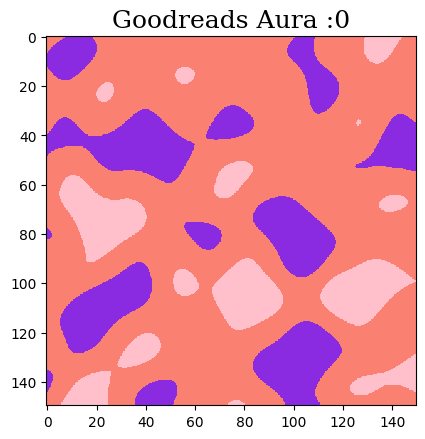

In [ ]:
my_cmap = ListedColormap(t3_colours) # our custom colour map
plt.imshow(pic, cmap = my_cmap)
font1 = {'family':'serif','color':'black','size':18} # change the font here
plt.title("Goodreads Aura :0", fontdict = font1)
plt.show()